# Amazon food review dataset apply GBDT to predict polarity review

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Here try BOW,TFIDF,avg W2V, avg TFIDFW2V and different hyperparameter GBDT(no of base learner,depth,learning rate)  
# Import data and libraries
 
 

In [15]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 
#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [16]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
#filtered_data.sample(5)
filtered_data['Score'].value_counts()
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [17]:
#take only 2500 + 2500 data
from sklearn.cross_validation import train_test_split,KFold
_ , clean_data = train_test_split(sorted_data, test_size = 10000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

positive    8432
negative    1568
Name: Score, dtype: int64

In [18]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1  
    
clean_data['CleanedText']=final_string
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data.sample(2)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
69317,75358,B002YR97QA,AJ1CD7OI9YFFZ,"Mary Frost ""mrtshome""",0,0,positive,1327795200,Teatulie tea with neem,This tea is interesting. My friend says neem ...,b'tea interest friend say neem tast take get u...
163375,177139,B005ZAULI6,A2TG5JHF4CCPGY,Jacqueline A. Johnson,0,0,positive,1328918400,We will see.,I have not had any of this tea yet as it only ...,b'tea yet arriv today told compani would recei...


# Split train and test data

In [19]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (7000,) (3000,) (7000,) (3000,)
positive and negative review in train and test
 positive    5939
negative    1061
Name: Score, dtype: int64 
 positive    2493
negative     507
Name: Score, dtype: int64


# Use GDDT
# BOW

In [20]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train_raw)

#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())
X_train_BOW=X_train
X_test_BOW=X_test

#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(7000, 11134) (3000, 11134)


In [21]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

# Use GBDT
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
learning_rate=[.9,.8,.1,.2]
n_estimators=[10,20,30]
max_depth=[3,4,5,6,7,8]
tuned_parameters=dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
#Using GridSearchCV
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumlearning_rate=model.best_estimator_.learning_rate
optimumn_estimators=model.best_estimator_.n_estimators
optimummax_depth=model.best_estimator_.max_depth
#build model with optimum parameter
model = GradientBoostingClassifier(learning_rate=optimumlearning_rate,n_estimators=optimumn_estimators, \
                    max_depth=optimummax_depth)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)


aa=pd.DataFrame({'type':['BOW GDDT'],'depth':[optimummax_depth],'estimator':[optimumn_estimators], \
                  'learningrate':[optimumlearning_rate],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})

Best parameters 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Predicted  negative  positive   All
Actual                             
negative        601       460  1061
positive          4      5935  5939
All             605      6395  7000


# TFIDF

In [22]:
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(X_train_raw)
#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
X_train_tfidf=X_train
X_test_tfidf=X_test

print(X_train.get_shape(),X_test.get_shape())
#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)


learning_rate=[.9,.8,.1,.2]
n_estimators=[10,20,30]
max_depth=[3,4,5,6,7,8]
tuned_parameters=dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
#Using GridSearchCV
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)
print('Best parameters \n',model.best_estimator_)
optimumlearning_rate=model.best_estimator_.learning_rate
optimumn_estimators=model.best_estimator_.n_estimators
optimummax_depth=model.best_estimator_.max_depth
#build model with optimum parameter
model = GradientBoostingClassifier(learning_rate=optimumlearning_rate,n_estimators=optimumn_estimators, \
                    max_depth=optimummax_depth)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['TFIDF GDDT'],'depth':[optimummax_depth],'estimator':[optimumn_estimators], \
                  'learningrate':[optimumlearning_rate],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)

(7000, 11134) (3000, 11134)
size of X_train, X_test, y_train , y_test  (7000, 11134) (3000, 11134) (7000,) (3000,)
Best parameters 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Predicted  negative  positive   All
Actual                             
negative        602       459  1061
positive          5      5934  5939
All             607      6393  7000


# AVG W2V

In [23]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent_train=[]
for sent in X_train_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)  

    
#convert W2V test data
i=0
#create a list of list to be used in W2V 
list_of_sent_test=[]
for sent in X_test_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

# try
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)
X_train_w2v=X_train
X_test_w2v=X_test
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Use GBDT
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

#GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0)

learning_rate=[.9,.8,.1,.2]
n_estimators=[8,12,15]
max_depth=[3,4,5,6,7,8]

tuned_parameters=dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)

#Using GridSearchCV
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)

print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumlearning_rate=model.best_estimator_.learning_rate
optimumn_estimators=model.best_estimator_.n_estimators
optimummax_depth=model.best_estimator_.max_depth

#build model with optimum parameter
model = GradientBoostingClassifier(learning_rate=optimumlearning_rate,n_estimators=optimumn_estimators, \
                    max_depth=optimummax_depth)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['AVG W2V GDDT'],'depth':[optimummax_depth],'estimator':[optimumn_estimators], \
                  'learningrate':[optimumlearning_rate],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)

size of X_train, X_test, y_train , y_test  (7000, 50) (3000, 50) (7000,) (3000,)
Best parameters 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=12,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Predicted  negative  positive   All
Actual                             
negative         57      1004  1061
positive          3      5936  5939
All              60      6940  7000


# AVG TFIDF W2V

In [24]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim

tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(X_train_raw)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
#tfidf_sent_vectors.

# do for test
final_tf_idf=tf_idf_vect.transform(X_test_raw)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train = pd.DataFrame(tfidf_sent_vectors_train)
X_test = pd.DataFrame(tfidf_sent_vectors_test)
X_train_w2vtfidf=X_train
X_test_w2vtfidf=X_test

print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Use GBDT
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

#GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0)

learning_rate=[.9,.8,.2]
n_estimators=[5,8,10]
max_depth=[3,4,5,6,7]

tuned_parameters=dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)

#Using GridSearchCV
model = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)


print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumlearning_rate=model.best_estimator_.learning_rate
optimumn_estimators=model.best_estimator_.n_estimators
optimummax_depth=model.best_estimator_.max_depth


#build model with optimum parameter
model = GradientBoostingClassifier(learning_rate=optimumlearning_rate,n_estimators=optimumn_estimators, \
                    max_depth=optimummax_depth,random_state=0)
model.fit(X_train, y_train)

#Store scores
pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn);fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn);fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['AVG W2V TFIDF GBDT'],'depth':[optimummax_depth],'estimator':[optimumn_estimators], \
                  'learningrate':[optimumlearning_rate],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)


size of X_train, X_test, y_train , y_test  (7000, 50) (3000, 50) (7000,) (3000,)
Best parameters 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Predicted  negative  positive   All
Actual                             
negative          2      1059  1061
positive          0      5939  5939
All               2      6998  7000


# plot for different values and accuracy

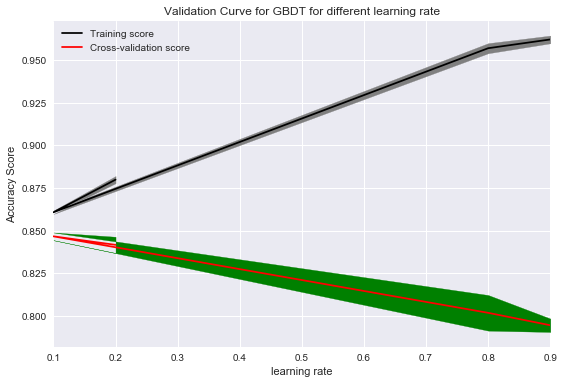

In [25]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
learning_rate=[.9,.8,.1,.2]
n_estimators=[5,8,10]
max_depth=[3,4,5,6,7]
param_range=[.9,.8,.1,.2]

train_scores, test_scores = validation_curve(GradientBoostingClassifier(), X_train, y_train, param_name="learning_rate", \
                                             param_range=learning_rate,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for GBDT for different learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy Score")
plt.xlim(.1,.9)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


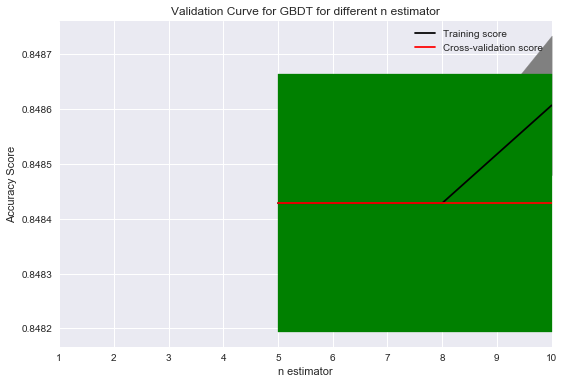

In [26]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
learning_rate=[.9,.8,.1,.2]
n_estimators=[5,8,10]
max_depth=[3,4,5,6,7]
param_range=[5,8,10]

train_scores, test_scores = validation_curve(GradientBoostingClassifier(), X_train, y_train, param_name="n_estimators", \
                                             param_range=n_estimators,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for GBDT for different n estimator")
plt.xlabel("n estimator")
plt.ylabel("Accuracy Score")
plt.xlim(1,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


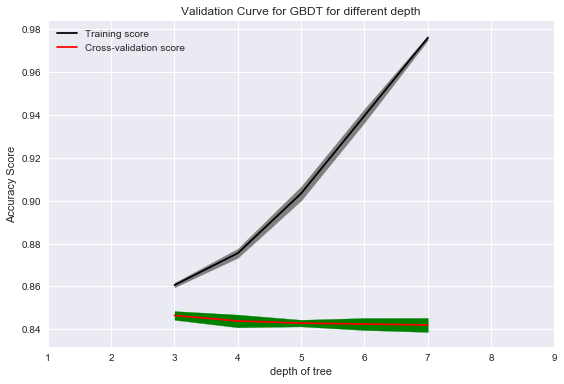

In [27]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
learning_rate=[.9,.8,.1,.2]
n_estimators=[5,8,10]
max_depth=[3,4,5,6,7]
param_range=[3,4,5,6,7]

train_scores, test_scores = validation_curve(GradientBoostingClassifier(), X_train, y_train, param_name="max_depth", \
                                             param_range=max_depth,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for GBDT for different depth")
plt.xlabel("depth of tree")
plt.ylabel("Accuracy Score")
plt.xlim(1,9)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Conclusion
GBDT is taking a lot of time for estimator 20/30

# Steps followed
Only !=3 reviews are taken Mark >3 as positive and <3 as negative. Sort data as per product id in ascending order Deduplication of entries for same profilename,userid, time, text and take first element Get stratified sampling of 10k data Clean html and punctuation Convert to uppercase and word<3 are rejected data sorted on time Split the data in train and test to 70:30

BOW
BOW BOW vec created using train data test data is converted using above on train and same applied to test 
do grid search for different value of learning_rate,n_estimators,max_depth. best model is established with best hyperparameter. model metric is stored in dataframe and crosstable is printed.

TFIDF
TFIDF form tfidf vec using train same is used in test to convert rest are same


AVG W2V 
gensim is used to convert train and test text to W2V AVG seperately rest are same

AVG TFIDF 
form tfidf vec using train same is used in test to convert gensim and above tfidf is used to convert train and test text to W2V AVG seperately

plot cv error with learning_rate,n_estimators,max_depth

Below is metric

In [29]:
aa

,accuracy_test,accuracy_train,depth,estimator,fscore_test,fscore_train,learningrate,type
0,0.864667,0.933714,7,30,0.923367,0.962380,0.2,BOW GDDT
0,0.866667,0.933714,7,30,0.924699,0.962374,0.2,TFIDF GDDT
0,0.828667,0.856143,4,12,0.906033,0.921811,0.2,AVG W2V GDDT
0,0.831000,0.848714,3,5,0.624343,0.918142,0.2,AVG W2V TFIDF GBDT
